In [4]:
import numpy as np
from keras.datasets import fashion_mnist 
import matplotlib.pyplot as plt

**Data Pre-Processing**

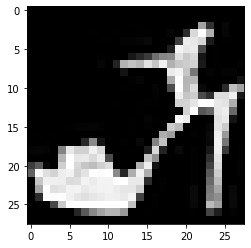

In [111]:
(X, y), (X_test, y_test) = fashion_mnist.load_data()
sample = 9
image = X[sample]
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [112]:
X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#One Hot Encoding for y
def one_hot_encode(y):
  encoded_array = np.zeros((y.size, y.max()+1), dtype=int)
  encoded_array[np.arange(y.size),y] = 1 
  return encoded_array

def softmax_to_label(softmax_output):
  max_index = np.argmax(softmax_output, axis = 0)
  return max_index


X = X/255
X_test = X_test/255
y = one_hot_encode(y)
y_test = one_hot_encode(y_test)


X = X.T
X_test = X_test.T
y = y.T

**Activation Functions**

In [7]:
def sigmoid(z):
    #print(-z)
    return 1 / (1 + np.exp(-(z)))

def tanh(z):
    return np.tanh(z)

def relu(z):
    return (z>0)*(z) + ((z<0)*(z)*0.01)

def softmax(x):
    # x = np.float128(x)
    temp = np.exp(x-np.max(x, axis = 0))
    fin = temp/temp.sum(axis = 0)
    
    return fin

**Weight Initialisation**

In [57]:
def initialize_parameters(input_size, n, output_size, initialisation):
  if (initialisation == 'Random'):
    parameters = {}
    parameters['W'+str(1)] = np.random.randn(n[0],input_size)*0.01
    parameters['b'+str(1)] = np.random.randn(n[0],1)
    for i in range(1,len(n)):
        parameters['W'+str(i+1)] = np.random.randn(n[i],n[i-1])*0.01
        parameters['b'+str(i+1)] = np.random.randn(n[i],1)
    parameters['W'+str(len(n)+1)] = np.random.randn(output_size,n[-1])*0.01
    parameters['b'+str(len(n)+1)] = np.random.randn(output_size,1)

  elif (initialisation == 'Xavier'):
    parameters = {}
    m = np.sqrt(6)/(input_size+n[0])
    parameters['W'+str(1)] = np.random.uniform(-m,m, (n[0],input_size))
    parameters['b'+str(1)] = np.random.randn(n[0],1)
    for i in range(1,len(n)):
        m = np.sqrt(6)/(n[i-1]+n[i])
        parameters['W'+str(i+1)] = np.random.uniform(-m,m, (n[i],n[i-1]) )
        parameters['b'+str(i+1)] = np.random.randn(n[i],1)
    m = np.sqrt(6)/(output_size+n[-1])
    parameters['W'+str(len(n)+1)] = np.random.uniform(-m,m,(output_size,n[-1]))
    parameters['b'+str(len(n)+1)] = np.random.randn(output_size,1)

  return parameters





def initialize_parameters_zeros(input_size, n, output_size):
    parameters = {}
    parameters['W'+str(1)] = np.zeros((n[0],input_size))
    parameters['b'+str(1)] = np.zeros((n[0],1))
    for i in range(1,len(n)):
        parameters['W'+str(i+1)] = np.zeros((n[i],n[i-1]))
        parameters['b'+str(i+1)] = np.zeros((n[i],1))
    parameters['W'+str(len(n)+1)] = np.zeros((output_size,n[-1]))
    parameters['b'+str(len(n)+1)] = np.zeros((output_size,1))
    return parameters

**Forward Propagation**

In [9]:
def linear(W, X, b, activation_func):
    #print(f"W Shape = {W.shape}, X Shape= {X.shape}, W= {W}, X = {X}, b = {b} " )
    h = np.matmul(W,X)+b
    if activation_func == 'sigmoid':
        #print(h)
        a = sigmoid(h)
    elif activation_func == 'relu':
        a = relu(h)
    elif activation_func == 'tanh':
        a = tanh(h)
    elif activation_func == 'softmax':
        a = softmax(h)
    return h,a

def ForwardPropagation(X, parameters, activation_func):
    layer_wise_outputs = {}
    layer_wise_outputs['h1'], layer_wise_outputs['a1'] = linear(parameters['W1'], X, parameters['b1'], activation_func[0])
    for i in range(1, (len(parameters)//2)):
        layer_wise_outputs['h'+str(i+1)], layer_wise_outputs['a'+str(i+1)] = linear(parameters['W'+str(i+1)],layer_wise_outputs['a'+str(i)],parameters['b'+str(i+1)], activation_func[i])
    return layer_wise_outputs

**Loss Functions and Accuracy**

In [90]:
def MSELoss(Y, Y_pred):
    MSE = np.mean((Y - Y_pred) ** 2, axis = 1)
    MSE = np.mean(MSE)
    return MSE

def CrossEntropyLoss(Y, Y_pred):
    CE = [-Y[i] * np.log(Y_pred[i]) for i in range(len(Y_pred))]
    crossEntropy = np.mean(CE)
    return crossEntropy

def cost(Y, Y_pred, loss_func):
    if (loss_func == 'MSE'):
        return (MSELoss(Y, Y_pred))
    elif (loss_func == 'CE'):
        return (CrossEntropyLoss(Y, Y_pred))

def accuracy_score(y_true, y_pred):
  correct = np.sum(y_true == y_pred)
  total = len(y_true)
  accuracy = correct / total
  return accuracy


**Back Propagation**

In [11]:
def ActivationBackward(dA, Z, activation_func) :
    
    if (activation_func == 'sigmoid'):
        grad = sigmoid(Z)*(1-sigmoid(Z))
       
    elif (activation_func == 'relu'):
        grad = np.where(Z>0, 1, 0)
        
    elif (activation_func == 'tanh'):
        grad = 1 - tanh(Z)**2
    elif (activation_func == 'softmax'):
        grad = softmax(Z) * (1-softmax(Z))
    dZ = dA * grad
    return dZ

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))        
    
def LayerBackward(dZl, Wl, bl, A_prev):
    
    m = A_prev.shape[1]
    # print(m)
    dWl = (1/m) * np.matmul(dZl, A_prev.T)
    dbl = (1/m)* np.sum(dZl, axis=1, keepdims=True)
    dA_prev = np.matmul(Wl.T,dZl)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dWl.shape == Wl.shape)
    assert (dbl.shape == bl.shape)
    return dWl, dbl, dA_prev
   
def BackPropagate(parameters, layer_wise_outputs,X, Y, activation_func, loss):
    gradients = {}
    l = len(layer_wise_outputs)//2
    m = Y.shape[1]
    AL = layer_wise_outputs['a'+str(l)]
    HL = layer_wise_outputs['h'+str(l)]
    
    if loss == 'CE':
        gradients['dh'+str(l)] = AL-Y
    elif loss == 'MSE':
        gradients['dh'+str(l)] = (AL-Y) * softmax_derivative(HL)
        
    for i in range(l-1,0,-1):
        gradients['dW'+str(i+1)],gradients['db'+str(i+1)],gradients['da'+str(i)] = LayerBackward(gradients['dh'+str(i+1)], parameters['W'+str(i+1)], parameters['b'+str(i+1)], layer_wise_outputs['a'+str(i)])
        gradients['dh'+str(i)] = ActivationBackward(gradients['da'+str(i)], layer_wise_outputs['h'+ str(i)] , activation_func[i-1])
        
    gradients['dW'+str(1)],gradients['db'+str(1)],gradients['da'+str(0)] = LayerBackward(gradients['dh'+str(1)], parameters['W'+str(1)], parameters['b'+str(1)], X)    
    
    return gradients


# parameters = initialize_parameters(2, [1,2,3], 2)
# activation_func = ['sigmoid','sigmoid','sigmoid','softmax']
# X = np.array([1,2]).reshape(2,1)  
# Y = np.array([1,2]).reshape(2,1)
# loss = 'CE'

# layer_wise_outputs = ForwardPropagation(X, parameters, activation_func)
# print(layer_wise_outputs)
# print(BackPropagate(parameters, layer_wise_outputs, X, Y, activation_func, loss))
# print(parameters['W3'].shape)
# print(BackPropagate(parameters, layer_wise_outputs, X, Y, activation_func, loss)['dW3'].shape)

**Optimisers**

In [12]:
class Optimiser:
    def __init__(self, lr):
        self.lr = lr

    def update(self, parameters, gradients):
        raise NotImplementedError

class SGD(Optimiser):
    def __init__(self, lr):
        super().__init__(lr)

    def update(self, parameters, gradients):
        L = len(parameters) // 2 
        for l in range(1, L + 1):
          parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * gradients["dW" + str(l)]
          parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * gradients["db" + str(l)]
        return parameters

class Momentum(Optimiser):
    def __init__(self, lr, beta):
        super().__init__(lr)
        self.beta = beta
        self.v = {}
  

    def update(self, parameters, gradients):
        L = len(parameters)//2
        if self.v == {}:
          for l in range(1, L + 1):
            self.v["W"+str(l)] = 0
            self.v["b"+str(l)] = 0
        for l in range(1, L + 1):
          self.v["W"+str(l)] = self.beta * self.v["W"+str(l)] + (1) * gradients["dW" + str(l)]
          parameters["W" + str(l)] = parameters["W" + str(l)] - self.lr * self.v["W"+str(l)]
          self.v["b"+str(l)] = self.beta * self.v["b"+str(l)] + (1) * gradients["db" + str(l)]
          parameters["b" + str(l)] = parameters["b" + str(l)] - self.lr * self.v["b"+str(l)]
        return parameters

class Nesterov(Optimiser):
    def __init__(self, lr, gamma):
        super().__init__(lr)
        self.gamma = gamma
        self.look_ahead = {}
        self.v = {}
        

    def update(self, parameters, gradients):
        L = len(parameters)//2
        if self.v == {}:
          for l in range(1, L + 1):
            self.v["W"+str(l)] = 0
            self.v["b"+str(l)] = 0
        if self.look_ahead == {}:
          for l in range(1, L + 1):
            self.look_ahead["W"+str(l)] = 0
            self.look_ahead["b"+str(l)] = 0

        for l in range(1, L + 1):
          self.look_ahead["W"+str(l)] = parameters["W" + str(l)]-self.gamma*self.v["W" + str(l)]
          parameters["W" + str(l)] = self.look_ahead["W"+str(l)] - self.lr * gradients["dW" + str(l)]
          self.v["W"+str(l)] = self.gamma * self.v["W"+str(l)] + self.lr * gradients["dW" + str(l)]

          self.look_ahead["b"+str(l)] = parameters["b" + str(l)]-self.gamma*self.v["b" + str(l)]
          parameters["b" + str(l)] = self.look_ahead["b"+str(l)] - self.lr * gradients["db" + str(l)]
          self.v["b"+str(l)] = self.gamma * self.v["b"+str(l)] + self.lr * gradients["db" + str(l)]

          
        return parameters

class RMSprop(Optimiser):
    def __init__(self, lr, decay_rate, eps):
        super().__init__(lr)
        self.decay_rate = decay_rate
        self.eps = eps
        self.s = {}


    def update(self, parameters, gradients):
        L = len(parameters)//2
        if self.s == {}:
          for l in range(1, L + 1):
            self.s["W"+str(l)] = 0
            self.s["b"+str(l)] = 0
        for l in range(1, L + 1):
          self.s["W"+str(l)] = self.decay_rate * self.s["W"+str(l)] + (1 - self.decay_rate) * (gradients["dW" + str(l)]**2)
          parameters["W" + str(l)] = parameters["W" + str(l)] - self.lr * gradients["dW" + str(l)] / (np.sqrt(self.s["W"+str(l)]) + self.eps)

          self.s["b"+str(l)] = self.decay_rate * self.s["b"+str(l)] + (1 - self.decay_rate) * (gradients["db" + str(l)]**2)
          parameters["b" + str(l)] = parameters["b" + str(l)] - self.lr * gradients["db" + str(l)] / (np.sqrt(self.s["b"+str(l)]) + self.eps)
        
        return parameters
        

class Adam(Optimiser):
    def __init__(self, lr, beta1, beta2, eps):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, parameters, gradients):
        L = len(parameters)//2
        if self.m == {}:
          for l in range(1, L + 1):
            self.m["W"+str(l)] = 0
            self.m["b"+str(l)] = 0
        if self.v == {}:
          for l in range(1, L + 1):
            self.v["W"+str(l)] = 0
            self.v["b"+str(l)] = 0
        self.t += 1

        for l in range(1, L + 1):
          self.m["W" + str(l)] = self.beta1 * self.m["W" + str(l)] + (1 - self.beta1) * gradients["dW" + str(l)]
          self.v["W" + str(l)] = self.beta2 * self.v["W" + str(l)] + (1 - self.beta2) * (gradients["dW" + str(l)]**2)
          m_hat = self.m["W" + str(l)] / (1 - self.beta1 ** self.t)
          v_hat = self.v["W" + str(l)] / (1 - self.beta2 ** self.t)
          parameters["W" + str(l)] = parameters["W" + str(l)] - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

          self.m["b" + str(l)] = self.beta1 * self.m["b" + str(l)] + (1 - self.beta1) * gradients["db" + str(l)]
          self.v["b" + str(l)] = self.beta2 * self.v["b" + str(l)] + (1 - self.beta2) * (gradients["db" + str(l)]**2)
          m_hat = self.m["b" + str(l)] / (1 - self.beta1 ** self.t)
          v_hat = self.v["b" + str(l)] / (1 - self.beta2 ** self.t)
          parameters["b" + str(l)] = parameters["b" + str(l)] - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
        
        
        return parameters

 
class Nadam(Optimiser):
    def __init__(self, lr, beta1, beta2, eps):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, parameters, gradients):
        L = len(parameters)//2
        if self.m == {}:
          for l in range(1, L + 1):
            self.m["W"+str(l)] = 0
            self.m["b"+str(l)] = 0
        if self.v == {}:
          for l in range(1, L + 1):
            self.v["W"+str(l)] = 0
            self.v["b"+str(l)] = 0
        self.t += 1

        for l in range(1, L + 1):
          self.m["W" + str(l)] = self.beta1 * self.m["W" + str(l)] + (1 - self.beta1) * gradients["dW" + str(l)]
          self.v["W" + str(l)] = self.beta2 * self.v["W" + str(l)] + (1 - self.beta2) * (gradients["dW" + str(l)]**2)
          m_hat = self.m["W" + str(l)] / (1 - self.beta1 ** self.t)
          v_hat = self.v["W" + str(l)] / (1 - self.beta2 ** self.t)
          m_hat_fin = (self.beta1*m_hat)+(1-self.beta1)*gradients["dW" + str(l)]/(1-(self.beta1)**self.t)
          parameters["W" + str(l)] = parameters["W" + str(l)] - self.lr * (m_hat_fin) / (np.sqrt(v_hat) + self.eps)

          self.m["b" + str(l)] = self.beta1 * self.m["b" + str(l)] + (1 - self.beta1) * gradients["db" + str(l)]
          self.v["b" + str(l)] = self.beta2 * self.v["b" + str(l)] + (1 - self.beta2) * (gradients["db" + str(l)]**2)
          m_hat = self.m["b" + str(l)] / (1 - self.beta1 ** self.t)
          v_hat = self.v["b" + str(l)] / (1 - self.beta2 ** self.t)
          m_hat_fin = (self.beta1*m_hat)+(1-self.beta1)*gradients["db" + str(l)]/(1-(self.beta1)**self.t)
          parameters["b" + str(l)] = parameters["b" + str(l)] - self.lr * (m_hat_fin) / (np.sqrt(v_hat) + self.eps)
        
        
        return parameters

**Training Our Model on Fashion-MNIST**


In [ ]:
#Model Architechture

n = [784,[64,32],10]
activation_func = ['sigmoid','sigmoid','softmax']
loss = 'MSE'
batch_size = 200
learning_rate = 0.001
# optimiser = SGD(lr = learning_rate)
# optimiser = Momentum(lr = learning_rate, beta = 0.2)
# optimiser = Nesterov(lr = learning_rate, gamma = 0.9)
# optimiser = RMSprop(lr = learning_rate, decay_rate = 0.1,eps = 1e-6)
# optimiser = Adam(lr = learning_rate, beta1 = 0.9, beta2 = 0.99 ,eps = 1e-6)
optimiser = Nadam(lr = learning_rate, beta1 = 0.9, beta2 = 0.99 ,eps = 1e-6)


epochs = 30
m = X.shape[1]
parameters = initialize_parameters(n[0],n[1],n[2], 'Random')
# parameters = parameters_test2
count = 0

#loss array 
# losses = np.array([])

while count < epochs :
  training_loss = 0
  count = count+1
  l = len(parameters)//2
  for i in np.arange(0, X.shape[1], batch_size):
    batch_count = batch_size
    if i + batch_size > X.shape[1]:
      batch_count = X.shape[1] - i + 1
    batch_size = batch_count

    layer_wise_outputs = ForwardPropagation(X[:,i:i+batch_size], parameters, activation_func)  
    gradients = BackPropagate(parameters, layer_wise_outputs, X[:,i:i+batch_size], y[:,i:i+batch_size], activation_func, loss)
    parameters = optimiser.update(parameters, gradients)
    training_loss = training_loss + cost(y[:,i:i+batch_size], layer_wise_outputs['a'+str(l)],loss)
  print("Loss after "+ str(count) +"th epoch =" +str(training_loss*(batch_size)/m))



test_outputs = ForwardPropagation(X_test, parameters, activation_func)


def softmax_to_label(softmax_output):
  max_index = np.argmax(softmax_output, axis = 0)
  return max_index

test_outputs['a'+str(len(parameters)//2)] = softmax_to_label(test_outputs['a'+str(len(parameters)//2)])


def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    accuracy = correct / total
    return accuracy

# print(softmax_to_label(y_test.T).shape)
# print(test_outputs['a'+str(len(n))].shape)
y_test_fin = softmax_to_label(y_test.T)
print(f"Test Accuracy = {100*accuracy_score( y_test_fin, test_outputs['a'+str(len(parameters)//2)])} %")

**Neural Network Class**

In [97]:

class Network():
  def __init__(self, N):
    self.n = N['n']
    self.parameters = initialize_parameters_zeros(self.n[0],self.n[1],self.n[2])
    self.activation_func = N['activation_func']
    self.l = len(self.parameters)//2

  def train(self,X,Y, initialisation, loss, batch_size, optimiser, epochs):
    self.parameters = initialize_parameters(self.n[0],self.n[1],self.n[2], initialisation )
    m = X.shape[1]
    count = 0
    while(count < epochs):
      count = count+1
      training_loss = 0
      for i in np.arange(0, X.shape[1], batch_size):
        batch_count = batch_size

        if i + batch_size > X.shape[1]:
          batch_count = X.shape[1] - i + 1
        batch_size = batch_count
        # print(self.parameters['W3'])
        layer_wise_outputs = ForwardPropagation(X[:,i:i+batch_size], self.parameters, self.activation_func)  
        
        gradients = BackPropagate(self.parameters, layer_wise_outputs, X[:,i:i+batch_size], y[:,i:i+batch_size], self.activation_func, loss)
        self.parameters = optimiser.update(self.parameters, gradients)
        training_loss = training_loss + cost(y[:,i:i+batch_size], layer_wise_outputs['a'+str(self.l)],loss)
      print("Loss after "+ str(count) +"th epoch =" +str(training_loss*(batch_size)/m))

  def test(self,X,Y):
    test_outputs = ForwardPropagation(X, self.parameters, self.activation_func)
    test_outputs['a'+str(self.l)] = softmax_to_label(test_outputs['a'+str(self.l)])
    y_test_fin = softmax_to_label(y_test.T)
    print(f"Test Accuracy = {100*accuracy_score( y_test_fin, test_outputs['a'+str(self.l)])} %")   

In [109]:
N = {'n' : [784,[64,32],10],
     'activation_func' : ['sigmoid','sigmoid','softmax']
     }


initialisation = 'Random'
batch_size = 200
epochs = 30
loss = 'CE'
learning_rate = 0.001
optimiser = Nadam(lr = learning_rate, beta1 = 0.9, beta2 = 0.99 ,eps = 1e-6)


network = Network(N)
network.train(X, y, initialisation, loss, batch_size, optimiser, epochs)
network.test(X_test, y_test)


Loss after 1th epoch =0.19972025896065695
Loss after 2th epoch =0.11504871057513767
Loss after 3th epoch =0.07792617872401338
Loss after 4th epoch =0.06264720425940802
Loss after 5th epoch =0.05189517538709645
Loss after 6th epoch =0.046502955106637
Loss after 7th epoch =0.04294790227374406
Loss after 8th epoch =0.040403458037017156
Loss after 9th epoch =0.03839718539135832
Loss after 10th epoch =0.03675541141443851
Loss after 11th epoch =0.03539357257741813
Loss after 12th epoch =0.034236630362564587
Loss after 13th epoch =0.03323036881715163
Loss after 14th epoch =0.03234228126738461
Loss after 15th epoch =0.03154813663464999
Loss after 16th epoch =0.030829113465535466
Loss after 17th epoch =0.030171659107045147
Loss after 18th epoch =0.02956566631374361
Loss after 19th epoch =0.02900214202413552
Loss after 20th epoch =0.028473297953605422
Loss after 21th epoch =0.027973582284306447
Loss after 22th epoch =0.02749987230745739
Loss after 23th epoch =0.027050105557498504
Loss after 24th